In [1]:
import sys
sys.path.append('C:\\Users\\DavidB\\PycharmProjects\\My_Football_Analytics\\Basics')
sys.path.append('C://Users//DavidB//PycharmProjects//My_Football_Analytics//Position_data')

import pandas as pd
import numpy as np
import torch
from torch.nn.functional import softplus
import Data.Metrica_IO as mio
from Tracking_Data import tracking_data

## set GPU or CPU (uncomment second line to use CPU)
# device = torch.device('cuda:0'); dtype = torch.float16
device = 'cpu'; dtype = torch.float32




In [2]:
data_dir = 'sample-data-master/data/'
game_id = 1
away = mio.tracking_data(DATADIR=data_dir, game_id=game_id, teamname='Away')
home = mio.tracking_data(DATADIR=data_dir, game_id=game_id, teamname='Home')
td = mio.merge_tracking_data(home, away)
td_object = tracking_data(td, data_source='metrica', scale_to_pitch='mplsoccer')
td_object.get_velocities()

td_object

Reading team: away
Reading team: home


In [3]:
# ball, and both team's position data in seperate data frames
Home = td_object.get_team('Home', selection='position', T_P=False)
Away = td_object.get_team('Away', selection='position', T_P=False)
Ball = td_object.get_ball(pos_only=True)

# velcoties as well

vel_Home = td_object.get_team('Home', selection='velocity', T_P=False)
vel_Away = td_object.get_team('Away', selection='velocity', T_P=False)
vel_Away

,Away_15_vx,Away_15_vy,Away_16_vx,Away_16_vy,Away_17_vx,Away_17_vy,Away_18_vx,Away_18_vy,Away_19_vx,Away_19_vy,...,Away_24_vx,Away_24_vy,Away_25_vx,Away_25_vy,Away_26_vx,Away_26_vy,Away_27_vx,Away_27_vy,Away_28_vx,Away_28_vy
Frame,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-1.397143,1.108571,-1.080000,-0.457143,-1.058571,-0.342857,-0.741429,-1.691429,-0.638571,-1.097143,...,-2.198571,1.328571,-1.268571,-0.251429,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,0.822857,-1.380000,0.385714,1.011429,0.000000,0.000000,0.000000,0.000000,NaN,NaN,...,NaN,NaN,0.000000,0.000000,0.334286,-1.011429,0.351429,0.245714,0.0,0.0
145003,0.951429,-1.025714,0.715714,0.737143,0.000000,0.000000,0.000000,0.000000,NaN,NaN,...,NaN,NaN,0.000000,0.000000,0.505714,-0.534286,0.407143,0.668571,0.0,0.0
145004,1.187143,-0.745714,1.048929,0.587857,0.000000,0.000000,0.000000,0.000000,NaN,NaN,...,NaN,NaN,0.000000,0.000000,0.696429,-0.067143,0.534643,1.005714,0.0,0.0


In [4]:
# both team's position data, velocities and ball to array

jitter = 1e-12 ## prevents division by zero when player is stationary



def pos_to_array(pos_data, nan_to=-1000, ball=False):
    if 'Period' in pos_data.columns or 'Time [s]' in pos_data.columns:
        raise ValueError('Data should include positon data only. Not any other columns!')
    n_players = int(len(pos_data.columns)/2)
    if ball==True:
        array = np.asarray(pos_data.iloc[:,range(0, 2)])[:,None,None,:]
    else:
        array = np.array([np.asarray(pos_data.iloc[:,range(j*2, j*2 +2)]) for j in range(n_players)])
    
    np.nan_to_num(array,copy=False,nan=nan_to)
    return array

A_Ball = pos_to_array(Ball, nan_to=np.nan, ball=True)
A_Home = pos_to_array(Home)
A_Away = pos_to_array(Away)
A_vel_Home = pos_to_array(vel_Home, nan_to=0.) + jitter
A_vel_Away = pos_to_array(vel_Away, nan_to=0.) + jitter

# severe changes in the shape of the arrays
# I am not 100% how and why this is necessary
# This is probably necessary for later 
A_Home = A_Home[:,1:,None,None,:]
A_Away = A_Away[:,1:,None,None,:]
A_vel_Home = A_vel_Home[:,1:,None,None,:]
A_vel_Away = A_vel_Away[:,1:,None,None,:]
A_Ball = A_Ball[None,1:]

print(A_Home.shape, A_Away.shape, A_Ball.shape, A_vel_Away.shape, A_vel_Home.shape)

(14, 145005, 1, 1, 2) (14, 145005, 1, 1, 2) (1, 145005, 1, 1, 2) (14, 145005, 1, 1, 2) (14, 145005, 1, 1, 2)


In [5]:
## set up evaluation grid and set some pitch control parameters (these are taken from the FoT code)
reaction_time = 0.7
max_player_speed = 5.
average_ball_speed = 15.
sigma = np.pi / np.sqrt(3.) / 0.45
lamb = 4.3
n_grid_points_x = 50
n_grid_points_y = 30
# create grid based on tensors
XX,YY = torch.meshgrid(torch.linspace(0,120,n_grid_points_x, device = device, dtype=dtype),
                       torch.linspace(0,80,n_grid_points_y,device=device,dtype=dtype))
target_position = torch.stack([XX,YY],2)[None,None,:,:,:] # all possible positions

print(XX.shape, YY.shape, target_position.shape)
target_position

torch.Size([50, 30]) torch.Size([50, 30]) torch.Size([1, 1, 50, 30, 2])


tensor([[[[[  0.0000,   0.0000],
           [  0.0000,   2.7586],
           [  0.0000,   5.5172],
           ...,
           [  0.0000,  74.4828],
           [  0.0000,  77.2414],
           [  0.0000,  80.0000]],

          [[  2.4490,   0.0000],
           [  2.4490,   2.7586],
           [  2.4490,   5.5172],
           ...,
           [  2.4490,  74.4828],
           [  2.4490,  77.2414],
           [  2.4490,  80.0000]],

          [[  4.8980,   0.0000],
           [  4.8980,   2.7586],
           [  4.8980,   5.5172],
           ...,
           [  4.8980,  74.4828],
           [  4.8980,  77.2414],
           [  4.8980,  80.0000]],

          ...,

          [[115.1020,   0.0000],
           [115.1020,   2.7586],
           [115.1020,   5.5172],
           ...,
           [115.1020,  74.4828],
           [115.1020,  77.2414],
           [115.1020,  80.0000]],

          [[117.5510,   0.0000],
           [117.5510,   2.7586],
           [117.5510,   5.5172],
           ...,
     

In [6]:
# the weights and the x-points of the Gauss–Legendre quadrature are set up and stored as torch tensors
# I assume that, as the Gauss–Legendre quadrature spans the range of [-1, 1] (length of 2), the 50 points selected
# represent the number of frames in a 2 second time period based on a framerate of 25Hz (i.e. 25 frames / second)
ti,wi = np.polynomial.legendre.leggauss(50) ## used for numerical integration later on
ti = torch.tensor(ti,device = device,dtype=dtype)
wi = torch.tensor(wi,device=device,dtype=dtype)
print(ti, wi)

tensor([-0.9989, -0.9940, -0.9854, -0.9729, -0.9566, -0.9367, -0.9131, -0.8860,
        -0.8554, -0.8216, -0.7846, -0.7445, -0.7016, -0.6559, -0.6077, -0.5572,
        -0.5045, -0.4498, -0.3934, -0.3355, -0.2763, -0.2160, -0.1549, -0.0932,
        -0.0311,  0.0311,  0.0932,  0.1549,  0.2160,  0.2763,  0.3355,  0.3934,
         0.4498,  0.5045,  0.5572,  0.6077,  0.6559,  0.7016,  0.7445,  0.7846,
         0.8216,  0.8554,  0.8860,  0.9131,  0.9367,  0.9566,  0.9729,  0.9854,
         0.9940,  0.9989]) tensor([0.0029, 0.0068, 0.0106, 0.0144, 0.0181, 0.0218, 0.0254, 0.0288, 0.0322,
        0.0355, 0.0386, 0.0415, 0.0443, 0.0470, 0.0494, 0.0517, 0.0537, 0.0556,
        0.0572, 0.0586, 0.0598, 0.0607, 0.0615, 0.0619, 0.0622, 0.0622, 0.0619,
        0.0615, 0.0607, 0.0598, 0.0586, 0.0572, 0.0556, 0.0537, 0.0517, 0.0494,
        0.0470, 0.0443, 0.0415, 0.0386, 0.0355, 0.0322, 0.0288, 0.0254, 0.0218,
        0.0181, 0.0144, 0.0106, 0.0068, 0.0029])


In [7]:
n_frames = A_Home.shape[1]
first_frame = 1
batch_size = 250

In [8]:
# time to intercept empty torch
tti = torch.empty([28,batch_size,n_grid_points_x,n_grid_points_y],device = device,dtype=dtype)
# 28 players*500 batches*grid
tmp2 = torch.empty([28,batch_size,n_grid_points_x,n_grid_points_y,1],device = device,dtype=dtype)
# 28 players*500 batches*grid * 1
pc = torch.empty([n_frames,n_grid_points_x,n_grid_points_y],device = device,dtype=dtype)
# frames * grid
print(tti.shape, tmp2.shape, pc.shape)


torch.Size([28, 250, 50, 30]) torch.Size([28, 250, 50, 30, 1]) torch.Size([145005, 50, 30])


In [9]:
n_frames = 250 # for speed just the first batch

for f in range(int(n_frames/batch_size)):
    bp = torch.tensor(A_Ball[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,
                                                                          int(first_frame + n_frames)))],
                      device = device,dtype=dtype)
    hp = torch.tensor(A_Home[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,
                                                                          int(first_frame + n_frames)))],
                      device = device,dtype=dtype)
    hv = torch.tensor(A_vel_Home[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,
                                                                        int(first_frame + n_frames)))],
                      device = device,dtype=dtype)
    ap = torch.tensor(A_Away[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,
                                                                          int(first_frame + n_frames)))],
                      device = device,dtype=dtype)
    av = torch.tensor(A_vel_Away[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,
                                                                        int(first_frame + n_frames)))],
                      device = device,dtype=dtype)
    
    print(bp.shape, hp.shape, hv.shape, ap.shape, av.shape)
    
    ball_travel_time = torch.norm(target_position - bp, dim=4).div_(average_ball_speed) 
    # ball travel time to each location in each frame in the batch
    
    r_reaction_home = hp + hv.mul_(reaction_time) # position after reaction time (vector)
    r_reaction_away = ap + av.mul_(reaction_time) # = position + velocity multiplied by reaction time
    r_reaction_home = r_reaction_home - target_position # distance to target position (vector)
    r_reaction_away = r_reaction_away - target_position # after reaction time
    
    print(hp.shape)
    print(tti.shape)
    print(r_reaction_home.shape)
    # time to intercept for home and away filled 
    # torch.norm --> distance of position in grid to target position from vector to value
    # add reaction time to time of intercept
    # divide distance by speed --> time of intercept
    # i think it should be the other way around! Divide first and then add reaction time
    tti[:14,:ball_travel_time.shape[1]] = torch.norm(r_reaction_home,dim=4).add_(reaction_time).div_(max_player_speed)
    tti[14:,:ball_travel_time.shape[1]] = torch.norm(r_reaction_away,dim=4).add_(reaction_time).div_(max_player_speed)
    # tti[:14,:ball_travel_time.shape[1]] = torch.norm(r_reaction_home,dim=4).div_(max_player_speed).add_(reaction_time)
    # tti[14:,:ball_travel_time.shape[1]] = torch.norm(r_reaction_away,dim=4).div_(max_player_speed).add_(reaction_time)

    tmp2[...,0] = sigma * (ball_travel_time - tti)
    
    tmp1 = sigma * 0.5 * (ti + 1) * 10 + tmp2
    
    # every players (scaled) time to control fed into a sigmoid function
    # --> probabilites [0,1], multiplied by lambda (default 4.3) --> range of [0, 4.3]
    hh = torch.sigmoid(tmp1[:14]).mul_(4.3)
    # teams intercept probability as the sum of players' control probabilities
    h = hh.sum(0)
    
    S = torch.exp(-lamb*torch.sum(softplus(tmp1) - softplus(tmp2),dim=0).div_(sigma))

    # numerische Integralbildung durch Gewichte (wi) durch Matrixvektorprukt aus Sh und den Gewichten 
    # i.e. Gewicht wird mit dem Entsprechenden der 50 Werte aus der Verteilung multipliziert
    pc[(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames)))] = torch.matmul(S*h,wi).mul_(5.)


torch.Size([1, 250, 1, 1, 2]) torch.Size([14, 250, 1, 1, 2]) torch.Size([14, 250, 1, 1, 2]) torch.Size([14, 250, 1, 1, 2]) torch.Size([14, 250, 1, 1, 2])
torch.Size([14, 250, 1, 1, 2])
torch.Size([28, 250, 50, 30])
torch.Size([14, 250, 50, 30, 2])


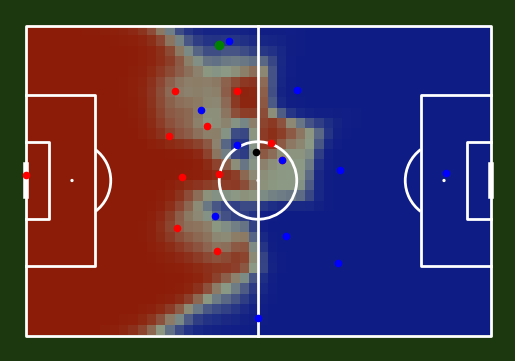

In [10]:
import matplotlib.pyplot as plt
cmap = 'bwr'

fig, ax = td_object.plot_players(frame=1, velocities=True)
ax.imshow(np.flipud(pc[1].rot90()), extent=(
    td_object.x_range_pitch[0], td_object.x_range_pitch[1], td_object.y_range_pitch[0],
    td_object.y_range_pitch[1]), cmap=cmap, alpha=0.5, vmin=0.0, vmax=1.0) # ensure correct orientation!
ax.scatter(50, 5, c='green')

In [11]:
mx = min(td_object.x_range_pitch)
td_object.x_range_pitch.index(mx)

0

In [12]:
S[1][21]

tensor([[0.9757, 0.8784, 0.7271,  ..., 0.0000, 0.0000, 0.0000],
        [0.9747, 0.8733, 0.7161,  ..., 0.0000, 0.0000, 0.0000],
        [0.9712, 0.8563, 0.6800,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.9740, 0.8702, 0.7087,  ..., 0.0000, 0.0000, 0.0000],
        [0.9756, 0.8778, 0.7257,  ..., 0.0000, 0.0000, 0.0000],
        [0.9760, 0.8800, 0.7304,  ..., 0.0000, 0.0000, 0.0000]])

In [13]:
pc.shape

torch.Size([145005, 50, 30])